In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize,rescale
from os import listdir

Using TensorFlow backend.


## We'll use a dirty document dataset to get clean denoised document texts

## We have to manually build our data

In [2]:
def build_data():
    
    x_train = []
    
    for file in listdir('kdd/train'):
    
        img = imread('kdd/train/' + file)
        
        img = resize(img,(260,540),True)
        
        img = img.reshape(1,img.shape[0],img.shape[1])
    
        
        x_train.append(img)
        
    
    x_train = tuple(x_train)
    
    x_train = np.concatenate(x_train)
    
    y_train = [] 
    
    
    for file in listdir('kdd/train_cleaned'):
    
        img = imread('kdd/train_cleaned/' + file)
        
        img = resize(img,(260,540),True)
        
        y_train.append(img.reshape(1,img.shape[0],img.shape[1]))
    
    
    
    y_train = tuple(y_train)
    
    y_train = np.concatenate(y_train)
    
    x_test = []
    
    for file in listdir('kdd/test'):
    
        img = imread('kdd/test/' + file)
        
        img = resize(img,(260,540),True)
        
        x_test.append(img.reshape(1,img.shape[0],img.shape[1]))
    
    
    
    x_test = tuple(x_test)
    
    x_test = np.concatenate(x_test)
    
    return x_train,y_train,x_test

In [3]:
x_train, y_train, x_test = build_data()

/home/igor/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/igor/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
x_train = np.reshape(x_train, (len(x_train), 260, 540, 1))
y_train = np.reshape(y_train, (len(x_train), 260, 540, 1))  
x_test = np.reshape(x_test, (len(x_test), 260, 540, 1)) 

## We have to split the dataset to train and validate

In [5]:
x_validation = x_train[121:145]
x_train = x_train[0:120]

y_validation = y_train[121:145]
y_train = y_train[0:120]

## Network hyperparameters

In [6]:
epochs = 100
input_shape = (260,540,1)
batch_size=12

## The encoder model

In [7]:
input_img = Input(shape=input_shape)
downConv = Conv2D(32,(3,3),activation='relu',padding='same')(input_img)
downConv = MaxPooling2D((2,2),padding='same')(downConv)
downConv = Conv2D(32,(3,3),activation='relu',padding='same')(downConv)

encoded = MaxPooling2D((2,2),padding='same')(downConv)

## The decoder model

In [8]:
upConv = Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
upConv = UpSampling2D((2,2))(upConv)
upConv = Conv2D(32,(3,3),activation='relu',padding='same')(upConv)
upConv = UpSampling2D((2,2))(upConv)


decoded = Conv2D(1,(3,3), activation='sigmoid', padding='same')(upConv)

## The autoencoder model

In [9]:
autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 260, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 260, 540, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 130, 270, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 270, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 135, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 135, 32)       9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 130, 270, 32)      0         
__________

## Training

In [10]:
autoencoder.fit(x_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_validation, y_validation),
                verbose=False)

## Let's check if our model actually works

In [11]:
denoised_imgs = autoencoder.predict(x_test)

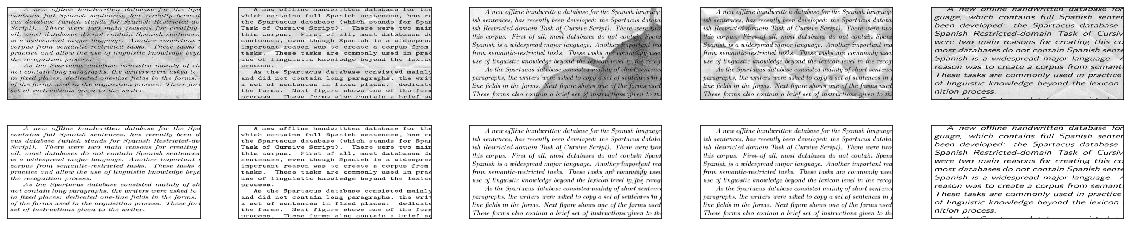

In [12]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(denoised_imgs[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### As you can see, we have a good clean reconstruction of these dirty (noised) documents